### Libraries and Data loading

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('HIGGS_8K_cleaned.csv', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,0.0,1.630428,0.404143,0.401026,2.722409,0.355644,1.362199,0.015818,-1.174111,0.000000,...,0.387635,1.596321,1.550981,0.859235,0.827233,0.995416,0.764766,0.520597,0.850413,0.929865
2,1.0,0.326305,-0.797735,0.223471,1.248234,-1.427857,0.923767,-0.278280,-0.470052,0.000000,...,-0.426866,1.153501,0.000000,0.887944,0.924601,0.987189,0.854094,0.385013,0.789912,0.724627
3,1.0,1.381170,0.521993,0.574698,0.357347,0.037136,0.413057,-0.607036,-1.308270,0.000000,...,0.567525,-1.475778,0.000000,0.936186,1.107217,0.983808,0.693327,0.562045,0.825387,0.846233
4,1.0,0.304161,-0.736375,0.686225,0.477172,-1.274736,0.907003,0.324770,-0.463954,2.173076,...,0.904818,1.165154,0.000000,1.181790,1.033701,0.993943,0.648399,0.936097,0.732592,0.661779


### Feature separation

In [18]:
# Features
features = {
    'all': data.iloc[:, 1:],
    'low': data.iloc[:, 1:22],
    'high': data.iloc[:, 22:]
}

# Target
target = data[0]

print(f"Number of features:")
print(f"- All: {features['all'].shape[1]}")
print(f"- Low-level: {features['low'].shape[1]}")
print(f"- High-level: {features['high'].shape[1]}")

Number of features:
- All: 28
- Low-level: 21
- High-level: 7


### Train/Test splitting

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features['all'], target, test_size=0.25, random_state=42)
Xl_train, Xl_test, _, _ = train_test_split(features['low'], target, test_size=0.25, random_state=42)
Xh_train, Xh_test, _, _ = train_test_split(features['high'], target, test_size=0.25, random_state=42)

print("Training set dimensions:")
print(f"- Full: {X_train.shape}, Low: {Xl_train.shape}, High: {Xh_train.shape}")

Training set dimensions:
- Full: (6000, 28), Low: (6000, 21), High: (6000, 7)


### Random Forest with RandomizedSearchCV

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5)
}

rf_models = {
    'all': RandomizedSearchCV(RandomForestClassifier(), param_dist, n_iter=20, cv=3, random_state=42),
    'low': RandomizedSearchCV(RandomForestClassifier(), param_dist, n_iter=20, cv=3, random_state=42),
    'high': RandomizedSearchCV(RandomForestClassifier(), param_dist, n_iter=20, cv=3, random_state=42)
}

In [21]:
rf_models['all'].fit(X_train, y_train)
rf_models['low'].fit(Xl_train, y_train)
rf_models['high'].fit(Xh_train, y_train)

print("Training completed!")

Training completed!


### Results

In [22]:
# Create DataFrame with all parameters
params_df = pd.DataFrame([
    rf_models['all'].best_params_,
    rf_models['low'].best_params_,
    rf_models['high'].best_params_
], index=['All', 'Low', 'High'])

# Add accuracy scores
params_df['Accuracy'] = [
    rf_models['all'].best_score_,
    rf_models['low'].best_score_,
    rf_models['high'].best_score_
]

display(params_df)

,max_depth,min_samples_leaf,min_samples_split,n_estimators,Accuracy
All,15.0,4,4,199,0.699000
Low,15.0,4,3,183,0.586500
High,NaN,3,8,70,0.693167


### Confusion Matrix

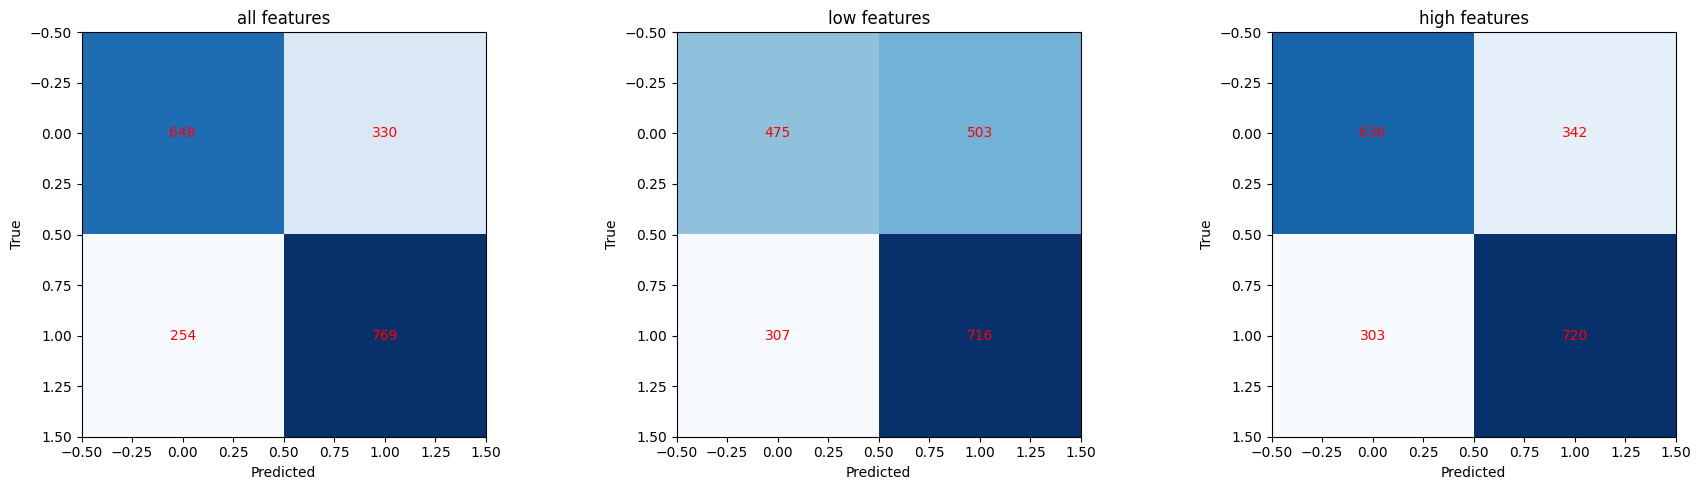

In [23]:
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 3, figsize=(18,5))

for ax, (name, model), X in zip(axes, rf_models.items(), [X_test, Xl_test, Xh_test]):
    cm = confusion_matrix(y_test, model.predict(X))
    ax.imshow(cm, cmap='Blues')
    ax.set_title(f'{name} features')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i,j], ha='center', va='center', color='red')

plt.tight_layout()
plt.show()

### Accuracy scores

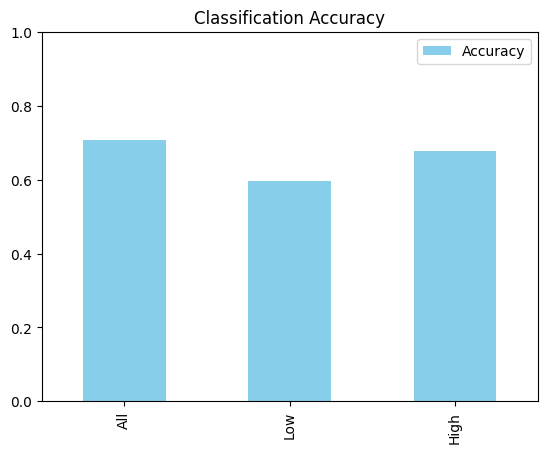

In [24]:
from sklearn.metrics import accuracy_score

accuracies = {
    'All': accuracy_score(y_test, rf_models['all'].predict(X_test)),
    'Low': accuracy_score(y_test, rf_models['low'].predict(Xl_test)),
    'High': accuracy_score(y_test, rf_models['high'].predict(Xh_test))
}

pd.DataFrame.from_dict(accuracies, orient='index', columns=['Accuracy']).plot.bar(color='skyblue')
plt.ylim(0.0, 1.0)
plt.title('Classification Accuracy')
plt.show()

### ROC Curves

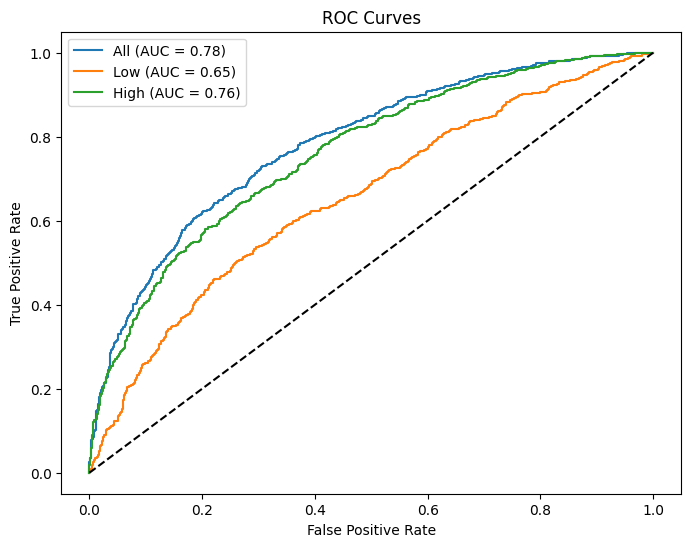

In [25]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))
for name, model, X in [('All', rf_models['all'], X_test),
                      ('Low', rf_models['low'], Xl_test),
                      ('High', rf_models['high'], Xh_test)]:
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

### AUC Scores

In [26]:
auc_scores = {
    'All': auc(*roc_curve(y_test, rf_models['all'].predict_proba(X_test)[:,1])[:2]),
    'Low': auc(*roc_curve(y_test, rf_models['low'].predict_proba(Xl_test)[:,1])[:2]),
    'High': auc(*roc_curve(y_test, rf_models['high'].predict_proba(Xh_test)[:,1])[:2])
}

pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC Score']).style.background_gradient()

,AUC Score
All,0.782527
Low,0.654491
High,0.760162
